In [9]:
%load_ext autoreload
from cppn_torch import ImageCPPN, CPPNConfig
from cppn_torch.fourier_features import add_fourier_features
from cppn_torch.activation_functions import *
from matplotlib import pyplot as plt
import imageio.v2 as iio
import numpy as np
from tqdm.notebook import trange


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


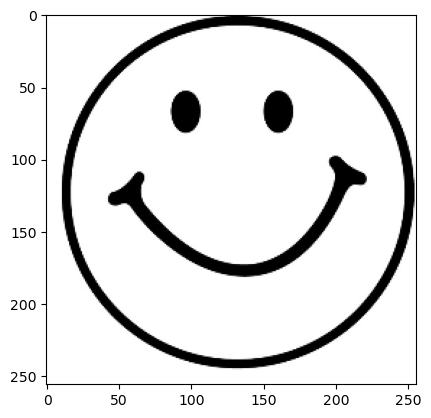

In [10]:
# target_img = iio.imread("https://upload.wikimedia.org/wikipedia/commons/6/61/Black_Circle.jpg") / 255.0
target_img = iio.imread("http://clipart-library.com/images/8cAb98X4i.jpg") / 255.0
import cv2
target_img = cv2.resize(target_img, (256, 256))
plt.imshow(target_img)

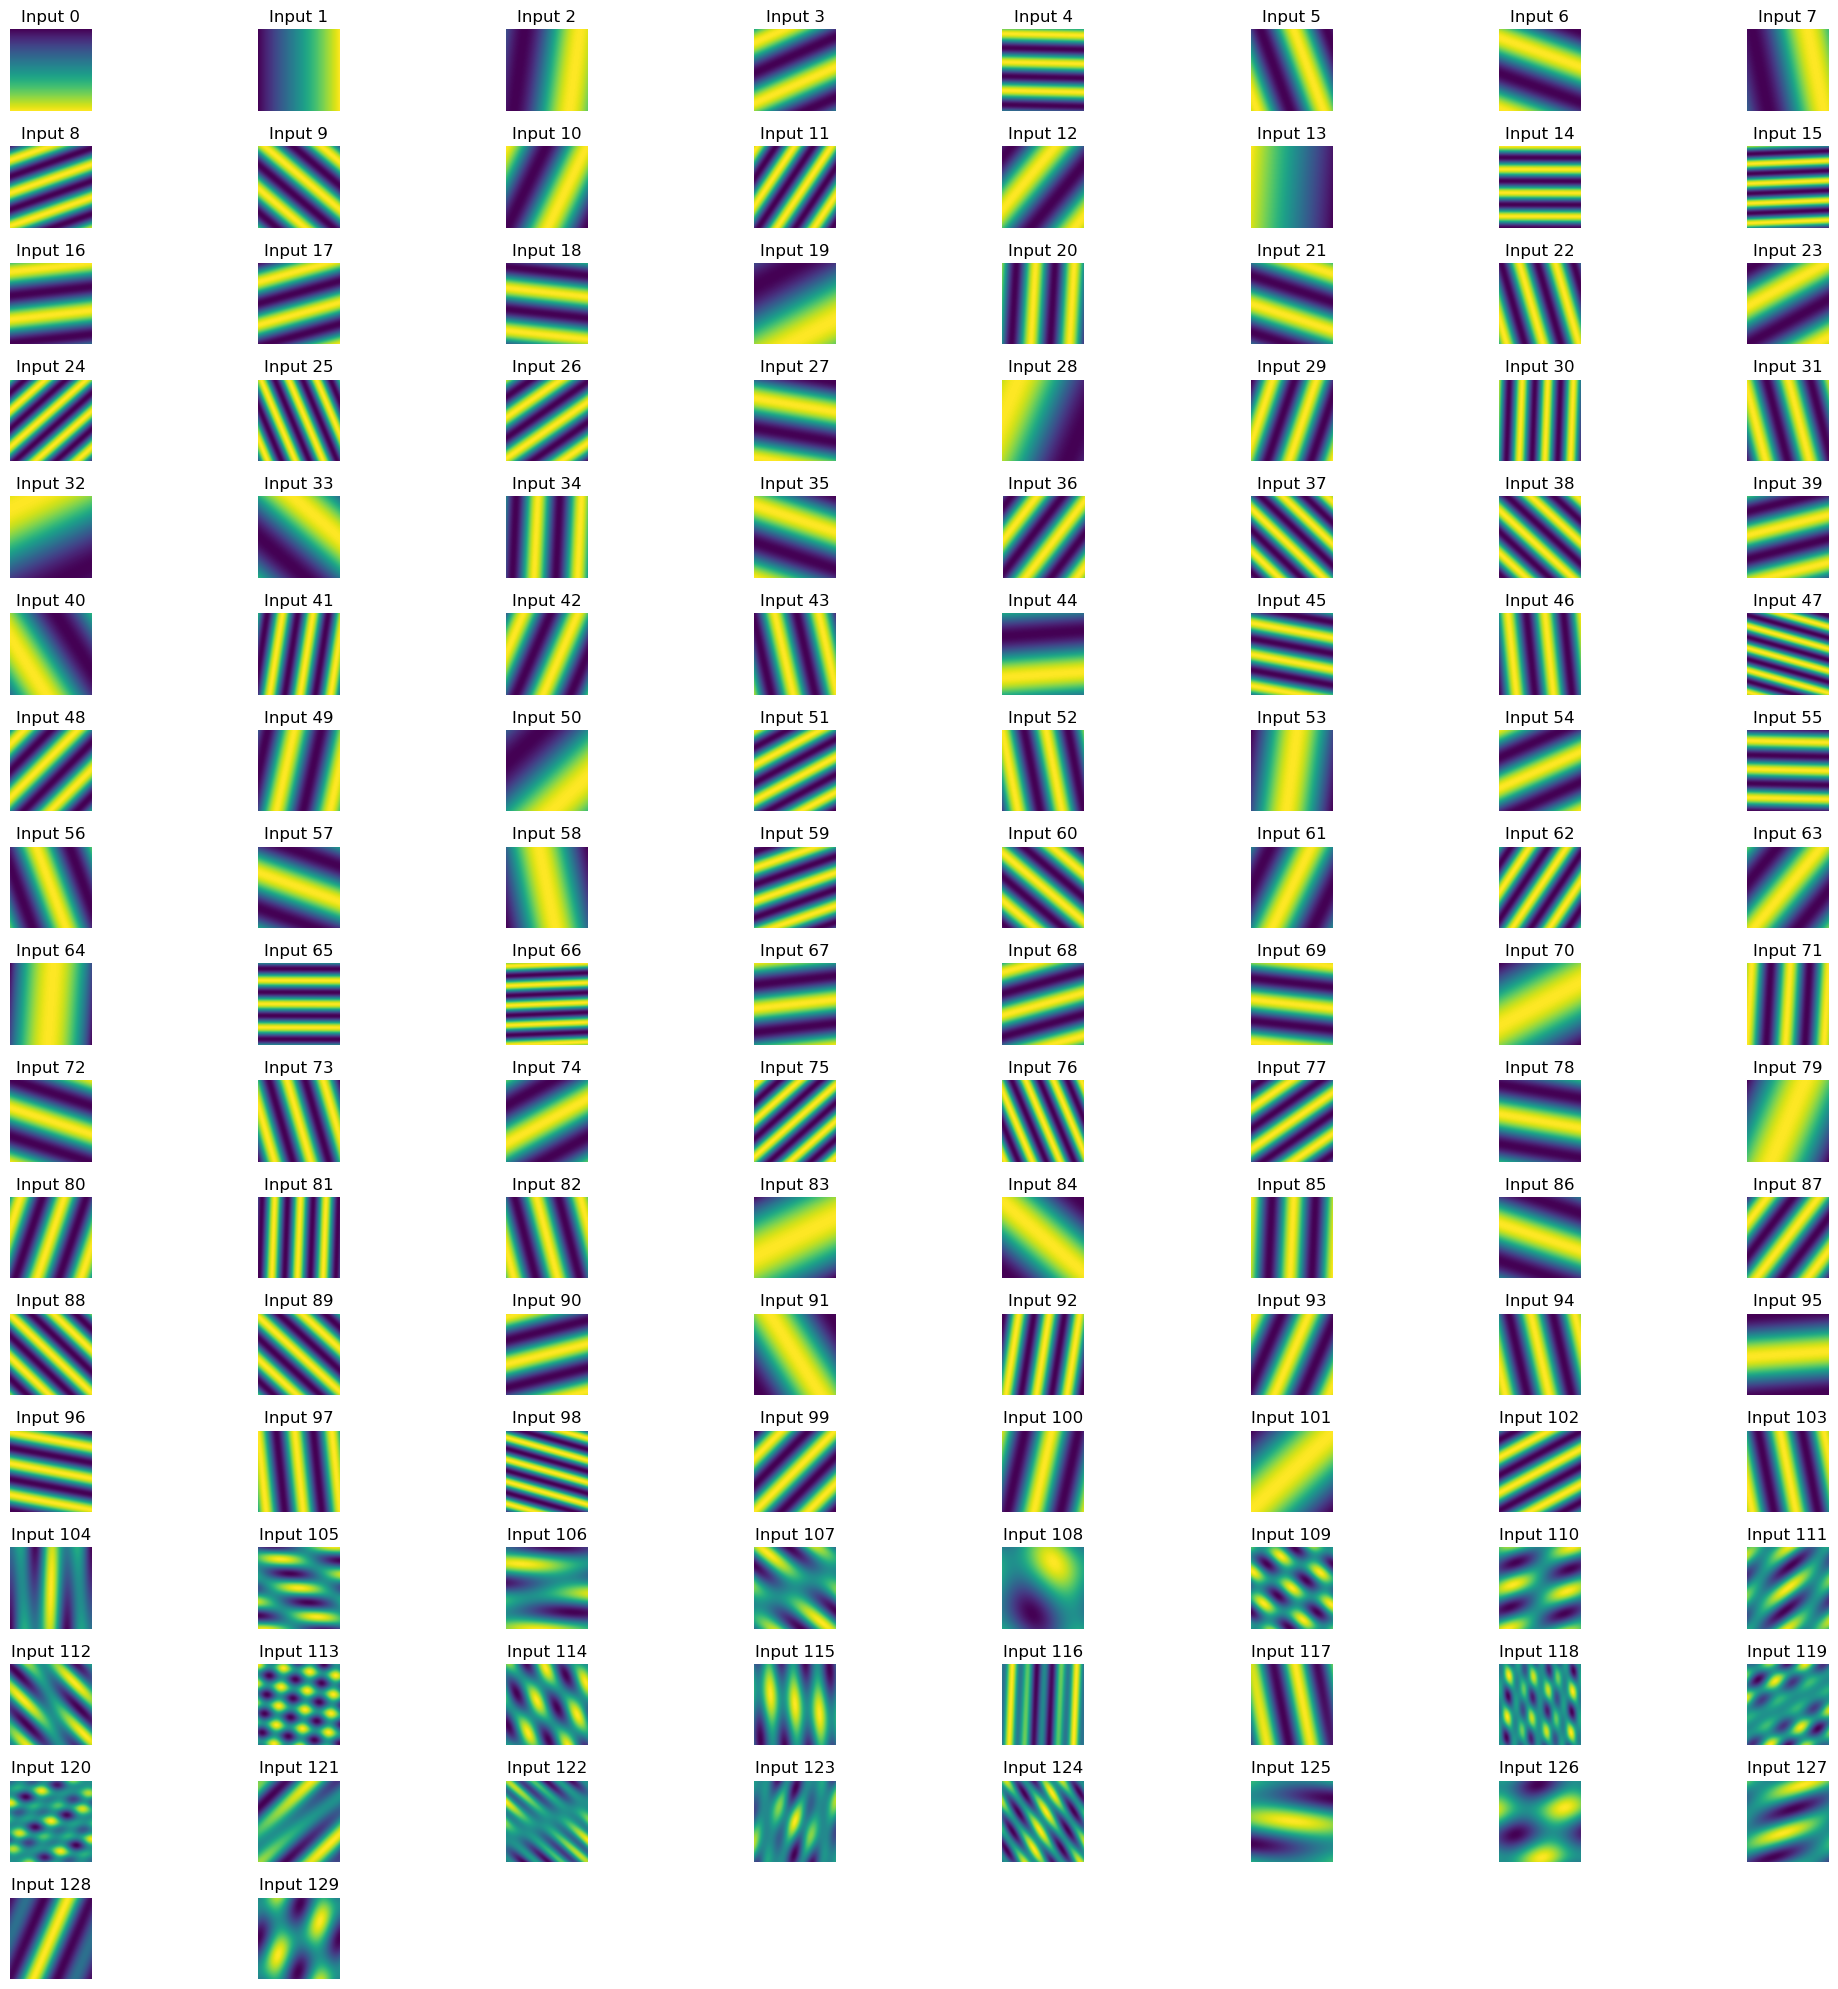

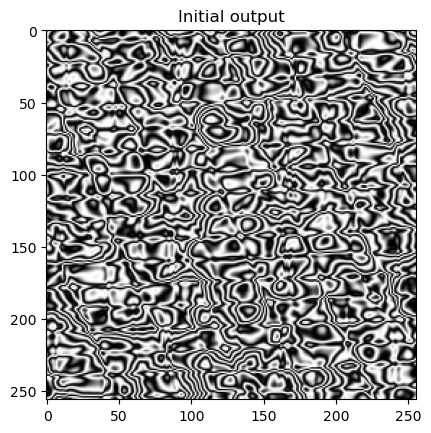

In [11]:
%autoreload 2
config = CPPNConfig()
config.set_res(target_img.shape[1], target_img.shape[0])
config.activations= [sin, cos, gauss, identity, sigmoid]
config.normalize_outputs= "sigmoid"
config.max_weight= 1.0
config.color_mode = "L"
config.with_grad = True
config.prob_mutate_weight = 0.0
config.prob_weight_reinit = 0.0
config.use_radial_distance = False
config.num_inputs = 2
config.hidden_nodes_at_start = 0

cppn = ImageCPPN(config)

inputs = cppn.initialize_inputs(
    res_h=config.res_h,
    res_w=config.res_w,
    use_radial_dist=config.use_radial_distance,
    use_bias=config.use_input_bias,
    n_inputs=config.num_inputs,
    device=config.device,
    coord_range=(-1, 1)
)

inputs = add_fourier_features(inputs,
                              128,
                              .8,
                              dims=config.num_inputs,
                              include_original=True,
                              mult_percent=.2
                              )
cols = 8
rows = 1 + inputs.shape[2] // cols
fig = plt.figure(figsize=(20,20))
for axis in range(inputs.shape[2]):
    plt.subplot(rows, cols, axis+1)
    plt.imshow(inputs[:, :, axis].detach().cpu(), cmap="viridis")
    plt.title(f"Input {axis}")
    plt.axis("off")
    plt.tight_layout()
plt.show()

cppn.config.num_inputs = inputs.shape[2]
cppn.reconfig()

for _ in range(100):
    cppn.mutate()

img = cppn(inputs).detach().cpu()
plt.title("Initial output")
plt.imshow(img, cmap="gray")
plt.show()


In [12]:
if config.color_mode == "L":
    target_img = target_img.mean(axis=2)
target = torch.tensor(target_img, dtype=torch.float32, device=config.device)

def loss_fn(img):
    return torch.mean((img - target)**2)

In [13]:
cppn.prepare_optimizer()
def sgd(steps=1000, lr=0.1, state_dict=None):
    losses = []
    params_over_time = []
    optimizer = torch.optim.Adam(cppn.params, lr=lr)
    
    if state_dict is not None:
        new_state_dict = optimizer.state_dict()
        state_dict.update(new_state_dict)
        optimizer.load_state_dict(state_dict)
        
    pbar = trange(steps, leave=False)
    for _ in pbar:
        optimizer.zero_grad()
        img = cppn(inputs)
        loss = loss_fn(img)
        loss.backward()
        optimizer.step()
        pbar.set_description_str(f"Id: {cppn.id} | Loss: {loss.item():.4f}")
        losses.append(loss.item())
        params = np.array([p.detach().cpu().item() for p in cppn.params])
        params = params.reshape(1, -1)
        [params_over_time.append(p) for p in params]
    return losses, np.stack(params_over_time, axis=1), optimizer.state_dict()

In [14]:
def evolve(iters):
    try:
        global cppn
        pbar = trange(iters)
        losses = []
        params_over_time = []
        state_dict = None        
        for _ in pbar:
            children = []
            for _ in range(5):
                child = cppn.clone(new_id=True)
                for _ in range(5):
                    child.mutate()
                children.append(child)
            children = [(child, loss_fn(child(inputs))) for child in children]
            children = sorted(children, key=lambda x: x[1])
            if children[0][1] < loss_fn(cppn(inputs)):
                cppn = children[0][0]
            cppn.prepare_optimizer()
            
            L,P,state_dict = sgd(300, 0.001, None)
            losses.extend(L)
            params_over_time.extend(P)
            
            img = cppn(inputs)
            loss = loss_fn(img)
            pbar.set_description_str(f"Id: {cppn.id} | Loss: {loss.item():.4f}")
    except KeyboardInterrupt:
        pass
    return losses, np.stack(params_over_time, axis=1)

In [15]:
# losses, params = sgd(1000,.001)
losses, params = evolve(100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

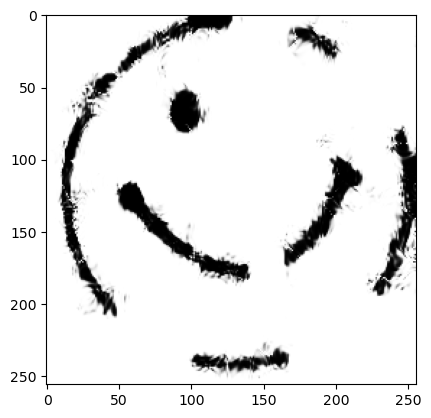

In [ ]:
img = cppn(inputs).detach().cpu()
plt.imshow(img, cmap="gray");

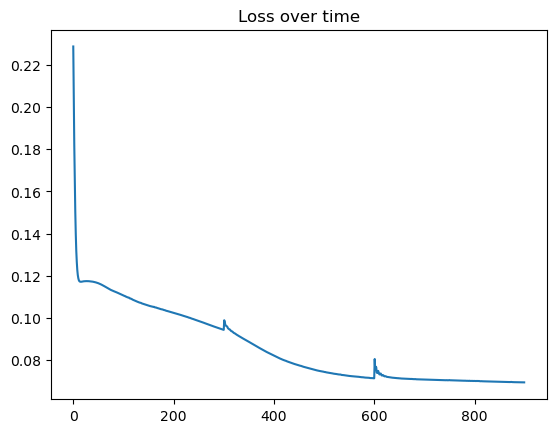

In [ ]:
plt.plot(losses)
plt.title("Loss over time");

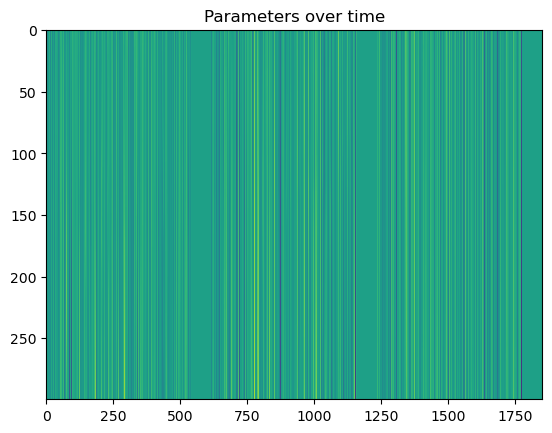

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(params, cmap="viridis", interpolation="none")
ax.set_aspect('auto')
ax.set_title("Parameters over time");

<Figure size 640x480 with 0 Axes>

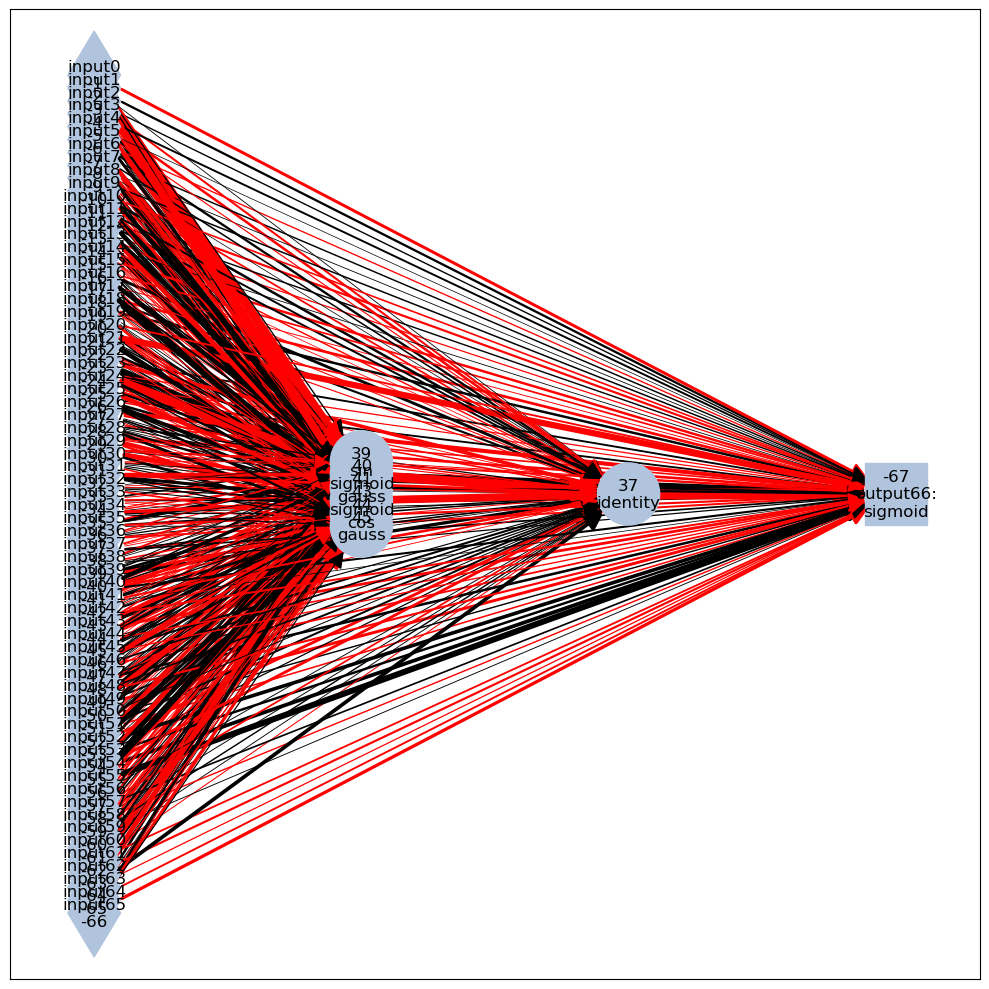

In [ ]:
from cppn_torch.util import visualize_network
# plt.figure(figsize=(3,30))
visualize_network(cppn)
# fig.set_size_inches(10,20)
plt.show()

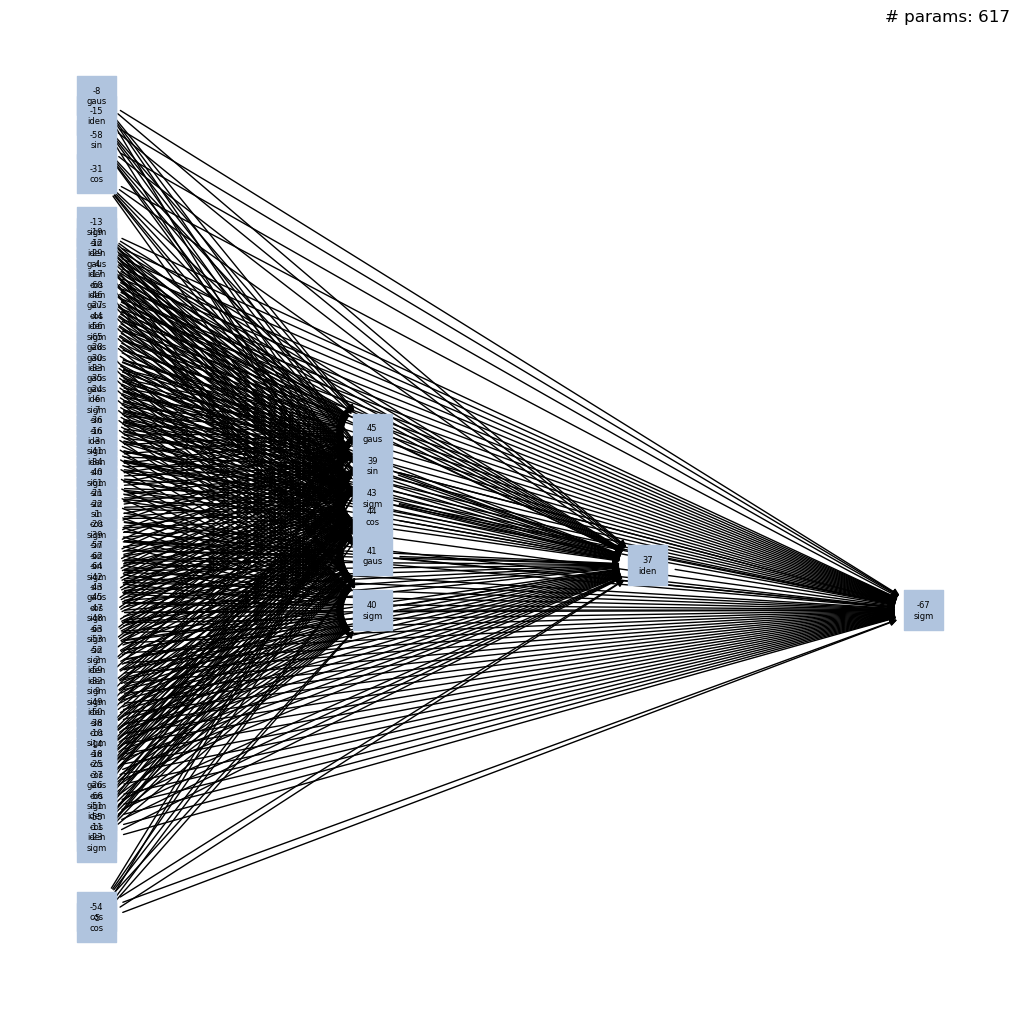

In [ ]:
cppn.draw_nx(size=(10,10))